In [2]:
import pandas as pd 
import numpy as np
import scipy.stats as stats

import seaborn as sn
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from src.processing import *
from src.wordcloud import *

/home/matt/portfolio/personal_portfolio/spotify


In [3]:
tracks = pd.read_csv('./data/tracks.csv')
artists = pd.read_csv('./data/artists.csv')

In [63]:
# process artists into distinct genre tags

cleaned_artists = clean_artists(artists)

1104349 total artists
298616 artists with labeled genres
459962 genre-artist pairs after processing


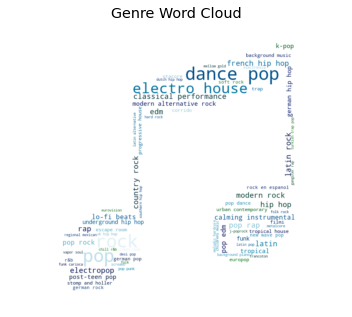

In [116]:
# generate word cloud of artist genres

mask = '/home/matt/portfolio/personal_portfolio/spotify/img/note.png'
masked_wordcloud(cleaned_artists, mask, 'genres_wordcloud', min_font = 7, colormap_choice='ocean')

In [74]:
### how do acoustic features change over time for all music? ###

cleaned_tracks = clean_tracks(tracks)

586672 total tracks
574073 tracks with 3 or fewer artists
689217 track-artist pairs after processing


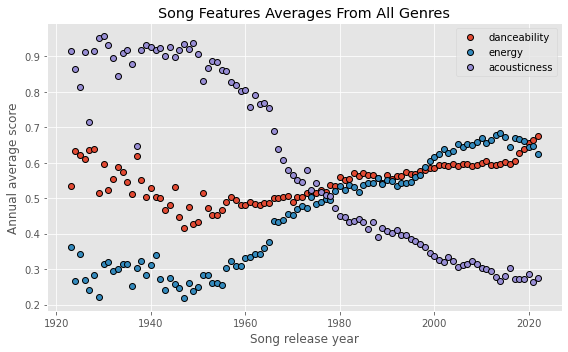

In [152]:
tracks_release_year = cleaned_tracks.groupby('release_date').mean()
tracks_release_year = tracks_release_year.reset_index()
tracks_release_year = tracks_release_year[1:]

fig, ax = plt.subplots(figsize=[8,5])
ax.plot_date(tracks_release_year['release_date'], tracks_release_year['danceability'], label='danceability', markeredgecolor='black')
ax.plot_date(tracks_release_year['release_date'], tracks_release_year['energy'], label='energy', markeredgecolor='black')
ax.plot_date(tracks_release_year['release_date'], tracks_release_year['acousticness'], label='acousticness', markeredgecolor='black')
# ax.plot_date(tracks_release_year['release_date'], tracks_release_year['liveness'], label='liveness', markeredgecolor='black')
# ax.plot_date(tracks_release_year['release_date'], tracks_release_year['valence'], label='valence', markeredgecolor='black')
ax.legend()
ax.set_ylabel('Annual average score')
ax.set_xlabel('Song release year')
plt.title('Song Features Averages From All Genres')
plt.tight_layout()
plt.savefig('/home/matt/portfolio/personal_portfolio/spotify/img/annual_avg_song_features.png')

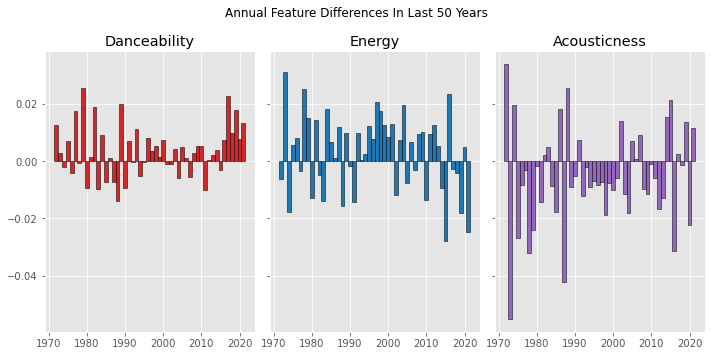

In [161]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(10,5))
ax[0].bar(tracks_release_year['release_date'].astype(str).astype(int)[-50:], tracks_release_year['danceability'].diff()[-50:],width=1.0, color='tab:red', ec='black')
ax[0].set_title('Danceability')
ax[1].bar(tracks_release_year['release_date'].astype(str).astype(int)[-50:], tracks_release_year['energy'].diff()[-50:],width=1.0, color='tab:blue', ec='black')
ax[1].set_title('Energy')
ax[2].bar(tracks_release_year['release_date'].astype(str).astype(int)[-50:], tracks_release_year['acousticness'].diff()[-50:],width=1.0, color='tab:purple', ec='black')
ax[2].set_title('Acousticness')
plt.suptitle('Annual Feature Differences In Last 50 Years')
plt.tight_layout()
plt.savefig('/home/matt/portfolio/personal_portfolio/spotify/img/annual_avg_song_features_diffs.png')

In [162]:


print('acousticness p-value: {}'.format(round(stats.ttest_1samp(tracks_release_year['danceability'].diff()[-50:],0, alternative='two-sided')[1], 3)))
print('energy p-value: {}'.format(round(stats.ttest_1samp(tracks_release_year['energy'].diff()[-50:],0, alternative='two-sided')[1], 3)))
print('liveness p-value: {}'.format(round(stats.ttest_1samp(tracks_release_year['acousticness'].diff()[-50:],0, alternative='two-sided')[1], 3)))

acousticness p-value: 0.008
energy p-value: 0.128
liveness p-value: 0.029


In [ ]:
# engineering features and recommendation system

